In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_targets

# load train, test, and validation datasets
train_targets = load_dataset('dogImages/train')
valid_targets = load_dataset('dogImages/valid')
test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]


Using TensorFlow backend.


In [ ]:
# Original data (DON'T NEED TO IMPPORT)

In [1]:
import numpy as np
x_train_aug = np.load(open('x_train_aug.npy'))
print(x_train_aug.shape)

(20040, 224, 224, 3)


In [2]:
import numpy as np
x_train_aug1 = np.load(open('x_aug1.npy'))

In [ ]:
# Original data labels (import in the beginning)

In [ ]:
import numpy as np
y_train_aug3x = np.load(open('y_train_aug.npy'))
print(y_train_aug.shape)

In [2]:
y_train_aug2x = np.load(open('y_aug1.npy'))
print(y_train_aug1.shape)

NameError: name 'y_train_aug1' is not defined

In [ ]:
# Transfer Learning. RESNET50

import numpy as np
train_resnet_features = np.load('bottleneck_features//train_resnet_features_aug.npy')
valid_resnet_features = np.load('bottleneck_features//valid_resnet_features_aug.npy')
test_resnet_features = np.load('bottleneck_features//test_resnet_features_aug.npy')


In [48]:
print(train_resnet_features.shape)

(20040, 1, 1, 2048)


In [49]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_resnet_features.shape[1:]))
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dropout(0.5))

ResNet_model.add(Dense(2 * 133,activation='relu'))
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dropout(0.5))

ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 266)               545034    
_________________________________________________________________
batch_normalization_14 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_14 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 133)               35511     
Total para

In [7]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/resnet_transfer_aug.hdf5', 
                               verbose=1, save_best_only=True)


history_resnet = ResNet_model.fit(train_resnet_features, y_train_aug3x, 
          batch_size = 128,
          epochs=30,
          verbose=1,
          validation_data=(valid_resnet_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=10)
          ])

Train on 20040 samples, validate on 835 samples
Epoch 1/30
20040/20040 [==============================] - 8s 377us/step - loss: 2.6095 - acc: 0.4049 - val_loss: 0.9840 - val_acc: 0.7581
Epoch 2/30
20040/20040 [==============================] - 1s 63us/step - loss: 1.0719 - acc: 0.7006 - val_loss: 0.6480 - val_acc: 0.8120
Epoch 3/30
20040/20040 [==============================] - 1s 61us/step - loss: 0.7683 - acc: 0.7762 - val_loss: 0.5737 - val_acc: 0.8228
Epoch 4/30
20040/20040 [==============================] - 1s 61us/step - loss: 0.6212 - acc: 0.8161 - val_loss: 0.5121 - val_acc: 0.8479
Epoch 5/30
20040/20040 [==============================] - 1s 59us/step - loss: 0.5278 - acc: 0.8400 - val_loss: 0.5126 - val_acc: 0.8335
Epoch 6/30
20040/20040 [==============================] - 1s 61us/step - loss: 0.4577 - acc: 0.8565 - val_loss: 0.4926 - val_acc: 0.8407
Epoch 7/30
20040/20040 [==============================] - 1s 61us/step - loss: 0.4171 - acc: 0.8699 - val_loss: 0.4855 - val_acc:

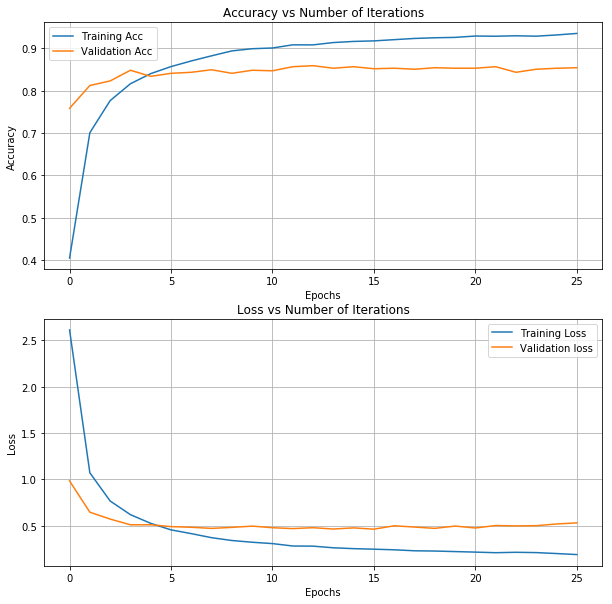

In [8]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_resnet.history['acc'], label = "Training Acc")
plt.plot(history_resnet.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_resnet.history['loss'], label = "Training Loss")
plt.plot(history_resnet.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_resnet_aug.png')
plt.show()


In [50]:
### Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/resnet_transfer_aug.hdf5')

In [11]:
# get index of predicted dog breed for each image in test set
ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(ResNet_predictions)==np.argmax(test_targets, axis=1))/len(ResNet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.1340%


In [12]:
# get index of predicted dog breed for each image in test set
ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_resnet_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(ResNet_predictions)==np.argmax(valid_targets, axis=1))/len(ResNet_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 85.1497%


In [ ]:
# INCEPTION

In [12]:
# Transfer Learning + Data Augmentation. inception50

In [51]:
import numpy as np
train_inception_features = np.load('bottleneck_features//train_inception_features_aug.npy')
valid_inception_features = np.load('bottleneck_features//valid_inception_features_aug.npy')
test_inception_features = np.load('bottleneck_features//test_inception_features_aug.npy')


In [52]:
print(train_inception_features.shape)

(20040, 5, 5, 2048)


In [53]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_inception_features.shape[1:]))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(0.5))

inception_model.add(Dense(2 * 133,activation='relu'))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(0.5))

inception_model.add(Dense(133, activation='softmax'))

inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 266)               545034    
_________________________________________________________________
batch_normalization_16 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_16 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 133)               35511     
Total para

In [17]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/inception_transfer_aug.hdf5', 
                               verbose=1, save_best_only=True)


history_inception = inception_model.fit(train_inception_features, y_train_aug3x, 
          batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=(valid_inception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=10)
          ])

Train on 20040 samples, validate on 835 samples
Epoch 1/30
20040/20040 [==============================] - 19s 951us/step - loss: 1.5201 - acc: 0.6154 - val_loss: 0.5785 - val_acc: 0.8251
Epoch 2/30
20040/20040 [==============================] - 19s 926us/step - loss: 0.9358 - acc: 0.7269 - val_loss: 0.5586 - val_acc: 0.8323
Epoch 3/30
20040/20040 [==============================] - 18s 921us/step - loss: 0.8368 - acc: 0.7570 - val_loss: 0.5170 - val_acc: 0.8491
Epoch 4/30
20040/20040 [==============================] - 18s 917us/step - loss: 0.7672 - acc: 0.7700 - val_loss: 0.5393 - val_acc: 0.8479
Epoch 5/30
20040/20040 [==============================] - 19s 935us/step - loss: 0.7060 - acc: 0.7892 - val_loss: 0.5377 - val_acc: 0.8419
Epoch 6/30
20040/20040 [==============================] - 19s 929us/step - loss: 0.6661 - acc: 0.7999 - val_loss: 0.5065 - val_acc: 0.8647
Epoch 7/30
20040/20040 [==============================] - 18s 919us/step - loss: 0.6419 - acc: 0.8049 - val_loss: 0.53

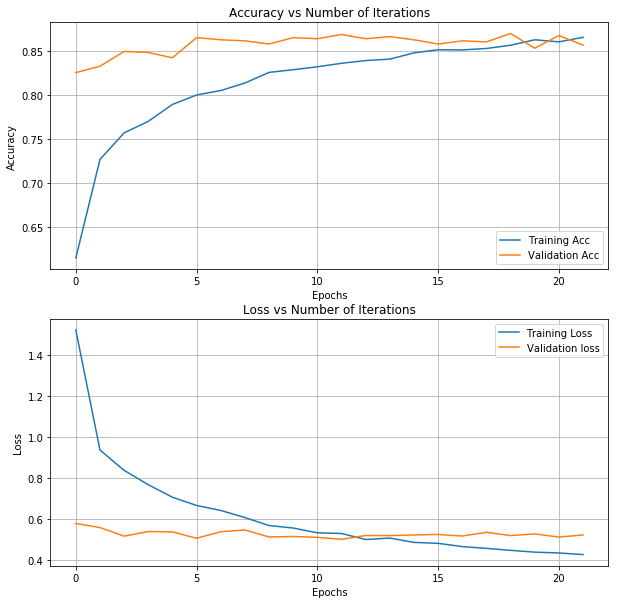

In [18]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_inception.history['acc'], label = "Training Acc")
plt.plot(history_inception.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_inception.history['loss'], label = "Training Loss")
plt.plot(history_inception.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_inception_aug.png')
plt.show()


In [54]:
### Load the model weights with the best validation loss.
inception_model.load_weights('saved_models/inception_transfer_aug.hdf5')

In [20]:
# get index of predicted dog breed for each image in test set
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.0478%


In [21]:
# get index of predicted dog breed for each image in test set
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_inception_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(inception_predictions)==np.argmax(valid_targets, axis=1))/len(inception_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 86.8263%


In [12]:
# Transfer Learning + Data Augmentation. xception

In [3]:
import numpy as np
train_xception_features = np.load('bottleneck_features//train_xception_features_aug.npy')
valid_xception_features = np.load('bottleneck_features//valid_xception_features_aug.npy')
test_xception_features = np.load('bottleneck_features//test_xception_features_aug.npy')


In [4]:
print(train_xception_features.shape)

(13360, 7, 7, 2048)


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


xception_model = Sequential()
xception_model.add(GlobalAveragePooling2D(input_shape=train_xception_features.shape[1:]))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.5))

xception_model.add(Dense(2 * 133,activation='relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.5))

xception_model.add(Dense(133, activation='softmax'))

xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 266)               545034    
_________________________________________________________________
batch_normalization_2 (Batch (None, 266)               1064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               35511     
Total para

In [7]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/xception_transfer_aug.hdf5', 
                               verbose=1, save_best_only=True)


history_xception = xception_model.fit(train_xception_features, y_train_aug2x, 
          batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=(valid_xception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=10)
          ])

Train on 13360 samples, validate on 835 samples
Epoch 1/30
13360/13360 [==============================] - 21s 2ms/step - loss: 1.6573 - acc: 0.5853 - val_loss: 0.5727 - val_acc: 0.8204
Epoch 2/30
13360/13360 [==============================] - 14s 1ms/step - loss: 0.9539 - acc: 0.7258 - val_loss: 0.5654 - val_acc: 0.8240
Epoch 3/30
13360/13360 [==============================] - 14s 1ms/step - loss: 0.8335 - acc: 0.7560 - val_loss: 0.5239 - val_acc: 0.8323
Epoch 4/30
13360/13360 [==============================] - 14s 1ms/step - loss: 0.7632 - acc: 0.7675 - val_loss: 0.4937 - val_acc: 0.8407
Epoch 5/30
13360/13360 [==============================] - 14s 1ms/step - loss: 0.7304 - acc: 0.7802 - val_loss: 0.5138 - val_acc: 0.8335
Epoch 6/30
13360/13360 [==============================] - 13s 1ms/step - loss: 0.6883 - acc: 0.7863 - val_loss: 0.4764 - val_acc: 0.8407
Epoch 7/30
13360/13360 [==============================] - 13s 995us/step - loss: 0.6504 - acc: 0.7982 - val_loss: 0.5104 - val_acc

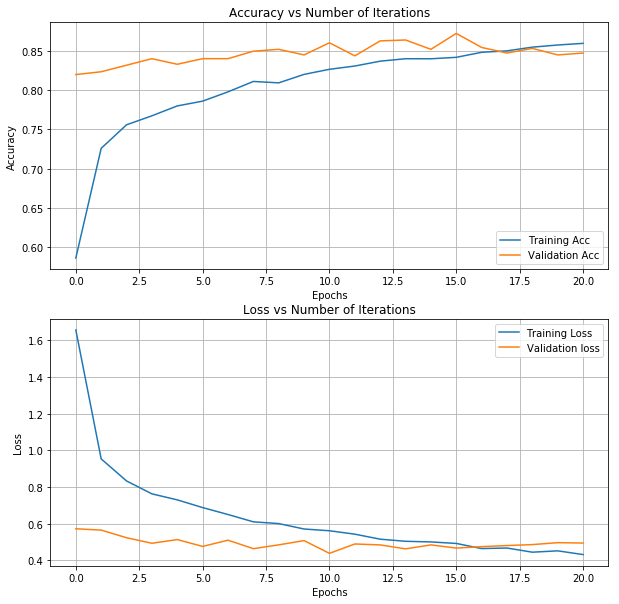

In [8]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_xception.history['acc'], label = "Training Acc")
plt.plot(history_xception.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_xception.history['loss'], label = "Training Loss")
plt.plot(history_xception.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_xception_aug.png')
plt.show()


In [9]:
### Load the model weights with the best validation loss.
xception_model.load_weights('saved_models/xception_transfer_aug.hdf5')

In [10]:
# get index of predicted dog breed for each image in test set
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.2871%


In [11]:
# get index of predicted dog breed for each image in test set
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_xception_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(xception_predictions)==np.argmax(valid_targets, axis=1))/len(xception_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 86.1078%


In [13]:
# Transfer Learning + Data Augmentation. vgg19

In [14]:
import numpy as np
train_vgg19_features = np.load('bottleneck_features//train_vgg19_features_aug.npy')
valid_vgg19_features = np.load('bottleneck_features//valid_vgg19_features_aug.npy')
test_vgg19_features = np.load('bottleneck_features//test_vgg19_features_aug.npy')


In [15]:
print(train_vgg19_features.shape)

(13360, 7, 7, 512)


In [33]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


vgg19_model = Sequential()
vgg19_model.add(GlobalAveragePooling2D(input_shape=train_vgg19_features.shape[1:]))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(2 * 133,activation='relu'))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(133, activation='softmax'))

vgg19_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 266)               136458    
_________________________________________________________________
batch_normalization_10 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_10 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               35511     
Total para

In [34]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/vgg19_transfer_aug.hdf5', 
                               verbose=1, save_best_only=True)


history_vgg19 = vgg19_model.fit(train_vgg19_features, y_train_aug2x, 
          batch_size = 32,
          epochs=50,
          verbose=1,
          validation_data=(valid_vgg19_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=10)
          ])

Train on 13360 samples, validate on 835 samples
Epoch 1/50
13360/13360 [==============================] - 4s 297us/step - loss: 3.4995 - acc: 0.2320 - val_loss: 1.3806 - val_acc: 0.6192
Epoch 2/50
13360/13360 [==============================] - 3s 246us/step - loss: 1.8305 - acc: 0.5022 - val_loss: 0.9483 - val_acc: 0.7377
Epoch 3/50
13360/13360 [==============================] - 3s 246us/step - loss: 1.3768 - acc: 0.6021 - val_loss: 0.8082 - val_acc: 0.7689
Epoch 4/50
13360/13360 [==============================] - 3s 244us/step - loss: 1.2351 - acc: 0.6331 - val_loss: 0.7234 - val_acc: 0.7832
Epoch 5/50
13360/13360 [==============================] - 3s 244us/step - loss: 1.1371 - acc: 0.6578 - val_loss: 0.6881 - val_acc: 0.7976
Epoch 6/50
13360/13360 [==============================] - 3s 245us/step - loss: 1.0653 - acc: 0.6754 - val_loss: 0.6851 - val_acc: 0.7772
Epoch 7/50
13360/13360 [==============================] - 3s 246us/step - loss: 1.0265 - acc: 0.6872 - val_loss: 0.6688 - va

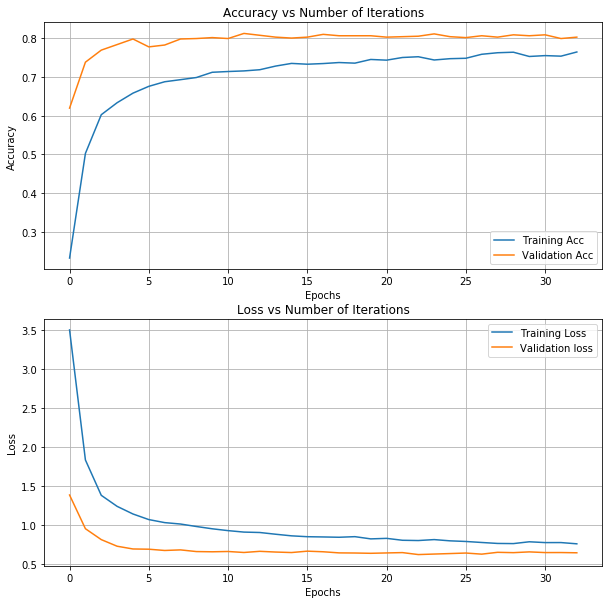

In [36]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_vgg19.history['acc'], label = "Training Acc")
plt.plot(history_vgg19.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history['loss'], label = "Training Loss")
plt.plot(history_vgg19.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_vgg19_aug.png')
plt.show()


In [37]:
### Load the model weights with the best validation loss.
vgg19_model.load_weights('saved_models/vgg19_transfer_aug.hdf5')

In [40]:
# get index of predicted dog breed for each image in test set
vgg19_predictions = [np.argmax(vgg19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg19_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(vgg19_predictions)==np.argmax(test_targets, axis=1))/len(vgg19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.5455%


In [39]:
# get index of predicted dog breed for each image in test set
vgg19_predictions = [np.argmax(vgg19_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_vgg19_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(vgg19_predictions)==np.argmax(valid_targets, axis=1))/len(vgg19_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 80.4790%


In [22]:
# Transfer Learning + Data Augmentation. vgg16

In [23]:
import numpy as np
train_vgg16_features = np.load('bottleneck_features//train_vgg16_features_aug.npy')
valid_vgg16_features = np.load('bottleneck_features//valid_vgg16_features_aug.npy')
test_vgg16_features = np.load('bottleneck_features//test_vgg16_features_aug.npy')


In [24]:
print(train_vgg16_features.shape)

(13360, 7, 7, 512)


In [41]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


vgg16_model = Sequential()
vgg16_model.add(GlobalAveragePooling2D(input_shape=train_vgg16_features.shape[1:]))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(2 * 133,activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(133, activation='softmax'))

vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 266)               136458    
_________________________________________________________________
batch_normalization_12 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_12 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 133)               35511     
Total para

In [42]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/vgg16_transfer_aug.hdf5', 
                               verbose=1, save_best_only=True)


history_vgg16 = vgg16_model.fit(train_vgg16_features, y_train_aug2x, 
          batch_size = 32,
          epochs=50,
          verbose=1,
          validation_data=(valid_vgg16_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=10)
          ])

Train on 13360 samples, validate on 835 samples
Epoch 1/50
13360/13360 [==============================] - 4s 302us/step - loss: 3.5814 - acc: 0.2144 - val_loss: 1.4676 - val_acc: 0.6443
Epoch 2/50
13360/13360 [==============================] - 3s 243us/step - loss: 1.8601 - acc: 0.4907 - val_loss: 0.9754 - val_acc: 0.7198
Epoch 3/50
13360/13360 [==============================] - 3s 244us/step - loss: 1.4432 - acc: 0.5814 - val_loss: 0.8456 - val_acc: 0.7545
Epoch 4/50
13360/13360 [==============================] - 3s 245us/step - loss: 1.2689 - acc: 0.6266 - val_loss: 0.7438 - val_acc: 0.7653
Epoch 5/50
13360/13360 [==============================] - 3s 244us/step - loss: 1.1793 - acc: 0.6491 - val_loss: 0.7118 - val_acc: 0.7808
Epoch 6/50
13360/13360 [==============================] - 3s 251us/step - loss: 1.1022 - acc: 0.6644 - val_loss: 0.7004 - val_acc: 0.7844
Epoch 7/50
13360/13360 [==============================] - 3s 246us/step - loss: 1.0462 - acc: 0.6841 - val_loss: 0.6707 - va

Epoch 29/50
13360/13360 [==============================] - 3s 242us/step - loss: 0.8345 - acc: 0.7374 - val_loss: 0.6315 - val_acc: 0.8012
Epoch 30/50
13360/13360 [==============================] - 3s 240us/step - loss: 0.8123 - acc: 0.7454 - val_loss: 0.6529 - val_acc: 0.7856
Epoch 31/50
13360/13360 [==============================] - 3s 240us/step - loss: 0.8075 - acc: 0.7438 - val_loss: 0.6378 - val_acc: 0.7964
Epoch 32/50
13360/13360 [==============================] - 3s 240us/step - loss: 0.8033 - acc: 0.7440 - val_loss: 0.6394 - val_acc: 0.7988
Epoch 33/50
13360/13360 [==============================] - 3s 240us/step - loss: 0.7857 - acc: 0.7501 - val_loss: 0.6189 - val_acc: 0.8024
Epoch 34/50
13360/13360 [==============================] - 3s 239us/step - loss: 0.7785 - acc: 0.7544 - val_loss: 0.6226 - val_acc: 0.7952
Epoch 35/50
13360/13360 [==============================] - 3s 239us/step - loss: 0.7864 - acc: 0.7452 - val_loss: 0.6259 - val_acc: 0.7988
Epoch 36/50
13360/13360 [==

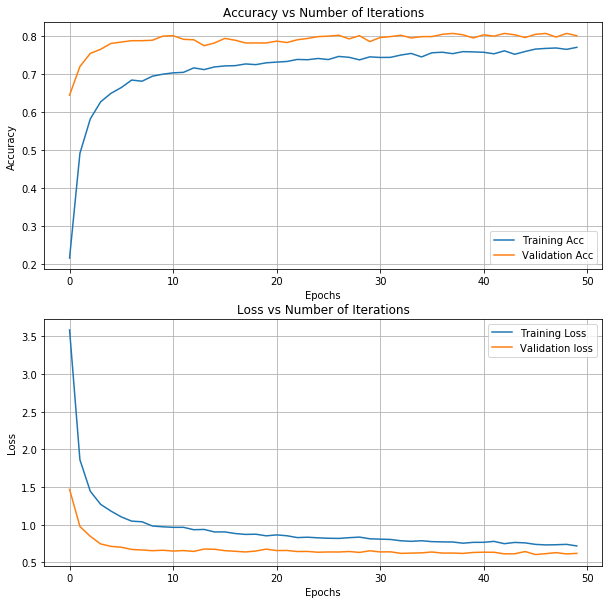

In [43]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_vgg16.history['acc'], label = "Training Acc")
plt.plot(history_vgg16.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_vgg16.history['loss'], label = "Training Loss")
plt.plot(history_vgg16.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_vgg16_aug.png')
plt.show()


In [44]:
### Load the model weights with the best validation loss.
vgg16_model.load_weights('saved_models/vgg16_transfer_aug.hdf5')

In [45]:
# get index of predicted dog breed for each image in test set
vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg16_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(vgg16_predictions)==np.argmax(test_targets, axis=1))/len(vgg16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.1435%


In [46]:
# get index of predicted dog breed for each image in test set
vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_vgg16_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(vgg16_predictions)==np.argmax(valid_targets, axis=1))/len(vgg16_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 80.4790%


In [ ]:
# INCEPTION

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
input_tensor = Input(shape = (224,224,3))
inception = InceptionV3(input_tensor = input_tensor, include_top=False, weights='imagenet')
print "Done extracting weights"

Done extracting weights


In [12]:
from keras.applications.inception_v3 import preprocess_input
train_tensors_inception = preprocess_input(x_train_aug)
# train_tensors_inception = preprocess_input(x_train_aug)


In [15]:
valid_tensors_inception = preprocess_input(valid_tensors_original)
test_tensors_inception = preprocess_input(test_tensors_original)

In [16]:
train_inception_features2 = inception.predict(train_tensors_inception)
print(train_inception_features2.shape)

(20040, 5, 5, 2048)


In [17]:
valid_inception_features = inception.predict(valid_tensors_inception)
print(valid_inception_features.shape)

(835, 5, 5, 2048)


In [18]:
test_inception_features = inception.predict(test_tensors_inception)
print(test_inception_features.shape)

(836, 5, 5, 2048)


In [20]:
np.save(open('bottleneck_features//train_inception_features.npy', 'w'), train_inception_features2)
np.save(open('bottleneck_features//valid_inception_features.npy', 'w'), valid_inception_features)
np.save(open('bottleneck_features//test_inception_features.npy', 'w'), test_inception_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception_features = bottleneck_features['train']
valid_inception_features = bottleneck_features['valid']
test_inception_features = bottleneck_features['test']

In [24]:
print(train_inception_features2.shape)

(20040, 5, 5, 2048)


In [30]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


Inception_model = Sequential()

Inception_model.add(GlobalAveragePooling2D(input_shape=train_inception_features2.shape[1:]))
Inception_model.add(BatchNormalization())
Inception_model.add(Dropout(0.5))
Inception_model.add(Dense(2 * 133,activation='relu'))
Inception_model.add(BatchNormalization())
Inception_model.add(Dropout(0.5))

Inception_model.add(Dense(133, activation='softmax'))
Inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 266)               545034    
_________________________________________________________________
batch_normalization_100 (Bat (None, 266)               1064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               35511     
Total para

In [31]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception_augmented.hdf5', 
                               verbose=1, save_best_only=True)


history_inception = Inception_model.fit(train_inception_features2, y_train_aug, 
          batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=(valid_inception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=10)
          ])

Train on 20040 samples, validate on 835 samples
Epoch 1/30
20040/20040 [==============================] - 21s 1ms/step - loss: 1.5124 - acc: 0.6151 - val_loss: 0.5707 - val_acc: 0.8240
Epoch 2/30
20040/20040 [==============================] - 20s 980us/step - loss: 0.9492 - acc: 0.7304 - val_loss: 0.5607 - val_acc: 0.8299
Epoch 3/30
20040/20040 [==============================] - 20s 978us/step - loss: 0.8247 - acc: 0.7584 - val_loss: 0.5347 - val_acc: 0.8491
Epoch 4/30
20040/20040 [==============================] - 20s 976us/step - loss: 0.7506 - acc: 0.7774 - val_loss: 0.5030 - val_acc: 0.8491
Epoch 5/30
20040/20040 [==============================] - 19s 960us/step - loss: 0.7071 - acc: 0.7874 - val_loss: 0.5421 - val_acc: 0.8407
Epoch 6/30
20040/20040 [==============================] - 19s 962us/step - loss: 0.6589 - acc: 0.8024 - val_loss: 0.5386 - val_acc: 0.8575
Epoch 7/30
20040/20040 [==============================] - 19s 959us/step - loss: 0.6293 - acc: 0.8028 - val_loss: 0.5662

In [48]:
print history_inception.history['acc']

[0.61511976047904193, 0.73043912175648706, 0.75843313373253496, 0.77744510978043913, 0.78742514970059885, 0.80239520958083832, 0.80284431137724555, 0.81177644710578845, 0.81801397205588822, 0.82749500998003989, 0.83003992015968064, 0.83727544910179641, 0.84001996007984037, 0.84316367265469061, 0.83852295409181632, 0.85154690618762474, 0.85054890219560875, 0.85603792415169666, 0.85573852295409181]


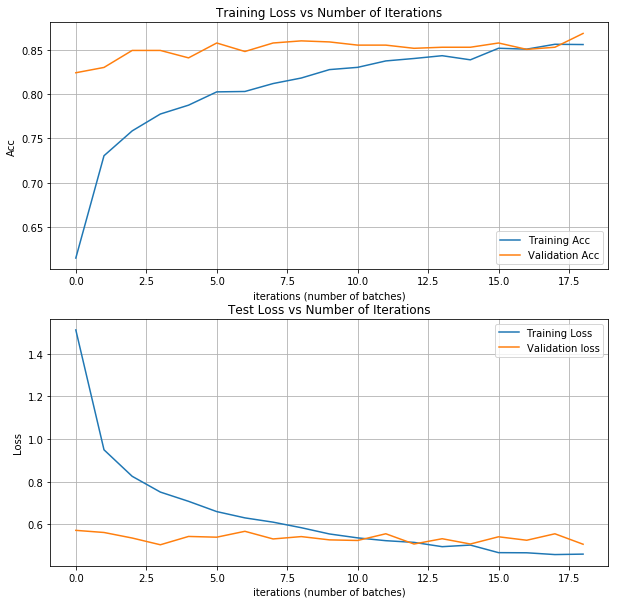

In [50]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_inception.history['acc'], label = "Training Acc")
plt.plot(history_inception.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("iterations (number of batches)")
plt.ylabel("Acc")
plt.title("Training Loss vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_inception.history['loss'], label = "Training Loss")
plt.plot(history_inception.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("iterations (number of batches)")
plt.ylabel("Loss")
plt.title("Test Loss vs Number of Iterations")
plt.grid()
plt.show()

In [46]:
### Load the model weights with the best validation loss.
Inception_model.load_weights('saved_models/weights.best.inception_augmented.hdf5')

NameError: name 'Inception_model' is not defined

In [35]:
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.0000%


In [ ]:
# xception

In [6]:
from keras.applications.xception import Xception
from keras.layers import Input
input_tensor = Input(shape = (224,224,3))
xception = Xception(input_tensor = input_tensor, include_top=False, weights='imagenet')
print "Done extracting weights"

Done extracting weights


In [23]:
from keras.applications.xception import preprocess_input
train_tensors_xception = preprocess_input(x_train_aug1)
# train_tensors_xception = preprocess_input(x_train_aug)


In [24]:
valid_tensors_xception = preprocess_input(valid_tensors_original)
test_tensors_xception = preprocess_input(test_tensors_original)

In [27]:
train_xception_features2 = xception.predict(train_tensors_xception)
print(train_xception_features2.shape)

(13360, 7, 7, 2048)


In [28]:
valid_xception_features = xception.predict(valid_tensors_xception)
print(valid_xception_features.shape)

(835, 7, 7, 2048)


In [29]:
test_xception_features = xception.predict(test_tensors_xception)
print(test_xception_features.shape)

(836, 7, 7, 2048)


In [ ]:
np.save(open('bottleneck_features//train_xception_features_aug.npy', 'w'), train_xception_features2)
np.save(open('bottleneck_features//valid_xception_features_aug.npy', 'w'), valid_xception_features)
np.save(open('bottleneck_features//test_xception_features_aug.npy', 'w'), test_xception_features)

In [30]:
print(train_xception_features2.shape)

(13360, 7, 7, 2048)


In [31]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


xception_model = Sequential()

xception_model.add(GlobalAveragePooling2D(input_shape=train_xception_features2.shape[1:]))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.5))
xception_model.add(Dense(2 * 133,activation='relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.5))

xception_model.add(Dense(133, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 266)               545034    
_________________________________________________________________
batch_normalization_6 (Batch (None, 266)               1064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               35511     
Total para

In [41]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception_augmented_2.hdf5', 
                               verbose=1, save_best_only=True)


history_xception = xception_model.fit(train_xception_features2, y_train_aug1,
          batch_size = 8,
          epochs=20,
          verbose=1,
          validation_data=(valid_xception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 13360 samples, validate on 835 samples
Epoch 1/20
13360/13360 [==============================] - 14s 1ms/step - loss: 0.5052 - acc: 0.8388 - val_loss: 0.4991 - val_acc: 0.8515
Epoch 2/20
13360/13360 [==============================] - 14s 1ms/step - loss: 0.5062 - acc: 0.8388 - val_loss: 0.4985 - val_acc: 0.8563
Epoch 3/20
13360/13360 [==============================] - 14s 1ms/step - loss: 0.4779 - acc: 0.8456 - val_loss: 0.4900 - val_acc: 0.8623
Epoch 4/20
13360/13360 [==============================] - 15s 1ms/step - loss: 0.4710 - acc: 0.8526 - val_loss: 0.4754 - val_acc: 0.8527
Epoch 5/20
13360/13360 [==============================] - 15s 1ms/step - loss: 0.4557 - acc: 0.8561 - val_loss: 0.4717 - val_acc: 0.8479
Epoch 6/20
13360/13360 [==============================] - 15s 1ms/step - loss: 0.4492 - acc: 0.8541 - val_loss: 0.4718 - val_acc: 0.8563
Epoch 7/20
13360/13360 [==============================] - 15s 1ms/step - loss: 0.4524 - acc: 0.8562 - val_loss: 0.5150 - val_acc: 

In [42]:
### Load the model weights with the best validation loss.
xception_model.load_weights('saved_models/weights.best.xception_augmented_2.hdf5')

In [43]:
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.4067%


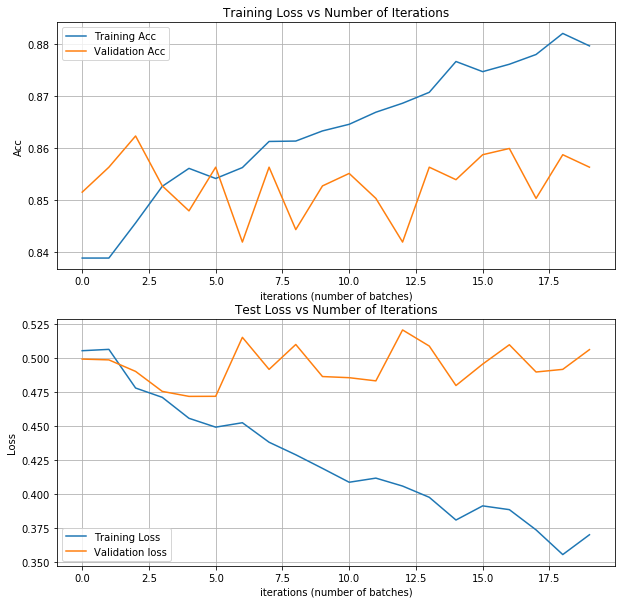

In [44]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_xception.history['acc'], label = "Training Acc")
plt.plot(history_xception.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("iterations (number of batches)")
plt.ylabel("Acc")
plt.title("Training Loss vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_xception.history['loss'], label = "Training Loss")
plt.plot(history_xception.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("iterations (number of batches)")
plt.ylabel("Loss")
plt.title("Test Loss vs Number of Iterations")
plt.grid()
plt.show()

In [ ]:
# vgg16

In [3]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet')
print "Done extracting weights"

Using TensorFlow backend.


Done extracting weights


In [4]:
from keras.applications.vgg16 import preprocess_input

train_tensors_vgg16 = preprocess_input(x_train_aug1)
valid_tensors_vgg16 = preprocess_input(valid_tensors_original)
test_tensors_vgg16 = preprocess_input(test_tensors_original)

In [12]:
print (train_tensors_vgg16.shape[0])

13360


In [13]:
train_vgg16_features = vgg16.predict(train_tensors_vgg16[0:10])
for i in np.arange(10, train_tensors_vgg16.shape[0], 10):
    print i
    y_predict0 = vgg16.predict(train_tensors_vgg16[i:i+10])
    train_vgg16_features = np.concatenate((train_vgg16_features, y_predict0), axis = 0)
print(train_vgg16_features.shape)

(13360, 7, 7, 512)


In [10]:
valid_vgg16_features = vgg16.predict(valid_tensors_vgg16[0:5])
for i in np.arange(5, valid_tensors_vgg16.shape[0], 10):
    y_predict0 = vgg16.predict(valid_tensors_vgg16[i:i+10])
    valid_vgg16_features = np.concatenate((valid_vgg16_features, y_predict0), axis = 0)
print(valid_vgg16_features.shape)


(835, 7, 7, 512)


In [11]:
test_vgg16_features = vgg16.predict(test_tensors_vgg16[0:6])
for i in np.arange(6, test_tensors_vgg16.shape[0], 10):
    y_predict0 = vgg16.predict(test_tensors_vgg16[i:i+10])
    test_vgg16_features = np.concatenate((test_vgg16_features, y_predict0), axis = 0)
print(test_vgg16_features.shape)

(836, 7, 7, 512)


In [14]:
np.save(open('bottleneck_features//train_vgg16_features_aug.npy', 'w'), train_vgg16_features)
np.save(open('bottleneck_features//valid_vgg16_features_aug.npy', 'w'), valid_vgg16_features)
np.save(open('bottleneck_features//test_vgg16_features_aug.npy', 'w'), test_vgg16_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/Dogvgg16V3Data.npz')
train_vgg16_features = bottleneck_features['train']
valid_vgg16_features = bottleneck_features['valid']
test_vgg16_features = bottleneck_features['test']

In [ ]:
print(train_vgg16_features.shape)

In [31]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


vgg16_model = Sequential()

vgg16_model.add(GlobalAveragePooling2D(input_shape=train_vgg16_features.shape[1:]))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(2 * 133,activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(133, activation='softmax'))
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 266)               136458    
_________________________________________________________________
batch_normalization_8 (Batch (None, 266)               1064      
_________________________________________________________________
dropout_8 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               35511     
Total para

In [32]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg16_augmented.hdf5', 
                               verbose=1, save_best_only=True)


history_vgg16 = vgg16_model.fit(train_vgg16_features, y_train_aug1, 
          batch_size = 8,
          epochs=50,
          verbose=1,
          validation_data=(valid_vgg16_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

NameError: name 'y_train_aug1' is not defined

In [21]:
### Load the model weights with the best validation loss.
vgg16_model.load_weights('saved_models/weights.best.vgg16_augmented.hdf5')

In [23]:
vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg16_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(vgg16_predictions)==np.argmax(test_targets, axis=1))/len(vgg16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.9043%


In [ ]:
# vgg19

In [3]:
from keras.applications.vgg19 import VGG19
vgg19 = VGG19(include_top=False, weights='imagenet')
print "Done extracting weights"

Using TensorFlow backend.


Done extracting weights


In [4]:
from keras.applications.vgg19 import preprocess_input

train_tensors_vgg19 = preprocess_input(x_train_aug1)
valid_tensors_vgg19 = preprocess_input(valid_tensors_original)
test_tensors_vgg19 = preprocess_input(test_tensors_original)

In [5]:
print (train_tensors_vgg19.shape[0])

13360


In [6]:
train_vgg19_features = vgg19.predict(train_tensors_vgg19[0:10])
for i in np.arange(10, train_tensors_vgg19.shape[0], 10):
    print i
    y_predict0 = vgg19.predict(train_tensors_vgg19[i:i+10])
    train_vgg19_features = np.concatenate((train_vgg19_features, y_predict0), axis = 0)
print(train_vgg19_features.shape)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [7]:
valid_vgg19_features = vgg19.predict(valid_tensors_vgg19[0:5])
for i in np.arange(5, valid_tensors_vgg19.shape[0], 10):
    y_predict0 = vgg19.predict(valid_tensors_vgg19[i:i+10])
    valid_vgg19_features = np.concatenate((valid_vgg19_features, y_predict0), axis = 0)
print(valid_vgg19_features.shape)


(835, 7, 7, 512)


In [8]:
test_vgg19_features = vgg19.predict(test_tensors_vgg19[0:6])
for i in np.arange(6, test_tensors_vgg19.shape[0], 10):
    y_predict0 = vgg19.predict(test_tensors_vgg19[i:i+10])
    test_vgg19_features = np.concatenate((test_vgg19_features, y_predict0), axis = 0)
print(test_vgg19_features.shape)

(836, 7, 7, 512)


In [9]:
np.save(open('bottleneck_features//train_vgg19_features_aug.npy', 'w'), train_vgg19_features)
np.save(open('bottleneck_features//valid_vgg19_features_aug.npy', 'w'), valid_vgg19_features)
np.save(open('bottleneck_features//test_vgg19_features_aug.npy', 'w'), test_vgg19_features)

In [ ]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/Dogvgg19V3Data.npz')
train_vgg19_features = bottleneck_features['train']
valid_vgg19_features = bottleneck_features['valid']
test_vgg19_features = bottleneck_features['test']

In [11]:
print(train_vgg19_features.shape)

(13360, 7, 7, 512)


In [12]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization


vgg19_model = Sequential()

vgg19_model.add(GlobalAveragePooling2D(input_shape=train_vgg19_features.shape[1:]))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dropout(0.5))
vgg19_model.add(Dense(2 * 133,activation='relu'))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(133, activation='softmax'))
vgg19_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 266)               136458    
_________________________________________________________________
batch_normalization_2 (Batch (None, 266)               1064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               35511     
Total para

In [15]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg19_augmented.hdf5', 
                               verbose=1, save_best_only=True)


history_vgg19 = vgg19_model.fit(train_vgg19_features, y_train_aug1, 
          batch_size = 16,
          epochs=30,
          verbose=1,
          validation_data=(valid_vgg19_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 13360 samples, validate on 835 samples
Epoch 1/30
13360/13360 [==============================] - 7s 504us/step - loss: 3.2641 - acc: 0.2540 - val_loss: 1.1975 - val_acc: 0.6862
Epoch 2/30
13360/13360 [==============================] - 5s 405us/step - loss: 1.7546 - acc: 0.5082 - val_loss: 0.8676 - val_acc: 0.7377
Epoch 3/30
13360/13360 [==============================] - 6s 412us/step - loss: 1.4354 - acc: 0.5797 - val_loss: 0.7713 - val_acc: 0.7617
Epoch 4/30
13360/13360 [==============================] - 5s 409us/step - loss: 1.3160 - acc: 0.6115 - val_loss: 0.7164 - val_acc: 0.7749
Epoch 5/30
13360/13360 [==============================] - 6s 413us/step - loss: 1.2681 - acc: 0.6253 - val_loss: 0.7124 - val_acc: 0.7772
Epoch 6/30
13360/13360 [==============================] - 6s 417us/step - loss: 1.2226 - acc: 0.6315 - val_loss: 0.6967 - val_acc: 0.7772
Epoch 7/30
13360/13360 [==============================] - 6s 415us/step - loss: 1.1715 - acc: 0.6488 - val_loss: 0.6716 - va

Epoch 29/30
13360/13360 [==============================] - 5s 407us/step - loss: 0.9205 - acc: 0.7175 - val_loss: 0.6355 - val_acc: 0.8048
Epoch 30/30
13360/13360 [==============================] - 5s 404us/step - loss: 0.9158 - acc: 0.7150 - val_loss: 0.6261 - val_acc: 0.8000


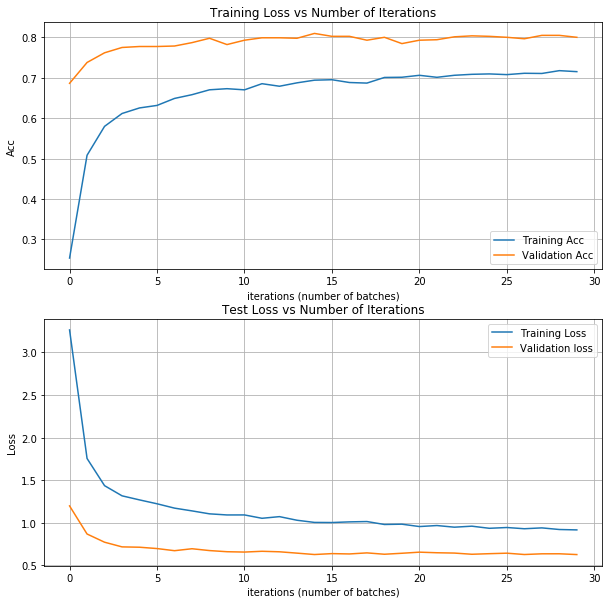

In [18]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_vgg19.history['acc'], label = "Training Acc")
plt.plot(history_vgg19.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("iterations (number of batches)")
plt.ylabel("Acc")
plt.title("Training Loss vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history['loss'], label = "Training Loss")
plt.plot(history_vgg19.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("iterations (number of batches)")
plt.ylabel("Loss")
plt.title("Test Loss vs Number of Iterations")
plt.grid()
plt.show()

In [19]:
### Load the model weights with the best validation loss.
vgg19_model.load_weights('saved_models/weights.best.vgg19_augmented.hdf5')

In [21]:
vgg19_predictions = [np.argmax(vgg19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg19_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(vgg19_predictions)==np.argmax(test_targets, axis=1))/len(vgg19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.5455%


In [61]:
# ENSEMBLE: valid accuracy

In [62]:
# Calculate prediction vectors
vgg16_predict_valid = vgg16_model.predict(valid_vgg16_features)
vgg19_predict_valid = vgg19_model.predict(valid_vgg19_features)
resnet_predict_valid = ResNet_model.predict(valid_resnet_features)
inception_predict_valid = inception_model.predict(valid_inception_features)
xception_predict_valid = xception_model.predict(valid_xception_features)

In [63]:
# Calculating "weights"
vgg16_valid_accuracy = 1.0*np.sum(np.argmax(vgg16_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
vgg19_valid_accuracy = 1.0*np.sum(np.argmax(vgg19_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
resnet_valid_accuracy = 1.0*np.sum(np.argmax(resnet_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
inception_valid_accuracy = 1.0*np.sum(np.argmax(inception_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
xception_valid_accuracy = 1.0*np.sum(np.argmax(xception_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)

In [64]:
ensemble_weights =  np.add(vgg16_valid_accuracy*vgg16_predict_valid, vgg19_valid_accuracy*vgg19_predict_valid)
ensemble_weights = np.add(ensemble_weights, resnet_valid_accuracy*resnet_predict_valid)
ensemble_weights = np.add(ensemble_weights, inception_valid_accuracy*inception_predict_valid)
ensemble_weights = np.add(ensemble_weights, xception_valid_accuracy*xception_predict_valid)
print ensemble_weights.shape

(835, 133)


In [65]:
ensemble_predictions = np.argmax(ensemble_weights, axis = 1)

In [66]:
ensemble_valid_accuracy = 100.0*np.sum(ensemble_predictions==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
print('validation accuracy: %.4f%%' % ensemble_valid_accuracy)

validation accuracy: 90.7784%


In [55]:
# ENSEMBLE: test accuracy

In [56]:
# Calculate prediction vectors
vgg16_predict_test = vgg16_model.predict(test_vgg16_features)
vgg19_predict_test = vgg19_model.predict(test_vgg19_features)
resnet_predict_test = ResNet_model.predict(test_resnet_features)
inception_predict_test = inception_model.predict(test_inception_features)
xception_predict_test = xception_model.predict(test_xception_features)

In [57]:
# Calculating "weights"
vgg16_test_accuracy = 1.0*np.sum(np.argmax(vgg16_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
vgg19_test_accuracy = 1.0*np.sum(np.argmax(vgg19_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
resnet_test_accuracy = 1.0*np.sum(np.argmax(resnet_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
inception_test_accuracy = 1.0*np.sum(np.argmax(inception_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
xception_test_accuracy = 1.0*np.sum(np.argmax(xception_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)

In [58]:
ensemble_weights =  np.add(vgg16_test_accuracy*vgg16_predict_test, vgg19_test_accuracy*vgg19_predict_test)
ensemble_weights = np.add(ensemble_weights, resnet_test_accuracy*resnet_predict_test)
ensemble_weights = np.add(ensemble_weights, inception_test_accuracy*inception_predict_test)
ensemble_weights = np.add(ensemble_weights, xception_test_accuracy*xception_predict_test)
print ensemble_weights.shape

(836, 133)


In [59]:
ensemble_predictions = np.argmax(ensemble_weights, axis = 1)

In [60]:
ensemble_test_accuracy = 100.0*np.sum(ensemble_predictions==np.argmax(test_targets, axis=1))/len(ensemble_predictions)
print('testation accuracy: %.4f%%' % ensemble_test_accuracy)

testation accuracy: 88.3971%
